In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis
import standard_sequences.spectroscopy as spec
import standard_sequences.rabi as rabi
import standard_sequences.T1_measurements as T1
import standard_sequences.ramsey as ramsey

In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
C3_address="GPIB0::10::INSTR"
C4_address="GPIB0::11::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc_34"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO_34"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)


In [4]:
q3 = Qubit(q3_dict, readout_dict)
q4 = Qubit(q4_dict, readout_dict)
readout = Readout(readout_dict)
q3.ROIF=q3.ro_freq-readout_dict["RO_LO_34"]
q4.ROIF=q4.ro_freq-readout_dict["RO_LO_34"]
print(f"{q3}\n{q4}")
bnc.set_DC_output(bnc_addr=C4_address, voltage=0)

Qubit(RO_LO_pwr=16, ge_ssm=-0.106, ef_ssm=None, mixer_offset_ef=None, RO_LO_34=6.4804, ro_freq=6.58374, ef_half_time=None, RO_IF=None, RO_LO_45=6.3804, ef_half_amp=None, RO_LO=6.6247, ef_amp=1, IQ_angle=25, qubit_thr=[-10000, 1900], qubit_id=q3, mixer_offset_ge=2.5, ef_time=None, ro_dur=3000, ROIF=0.10333999999999932, ro_amp=0.7, ge_time=75, ge_amp=1)
Qubit(RO_LO_pwr=16, ge_ssm=-0.252, ef_ssm=None, mixer_offset_ef=None, RO_LO_34=6.4804, ro_freq=6.51117, ef_half_time=None, RO_IF=None, RO_LO_45=6.3804, ef_half_amp=None, RO_LO=6.6247, ef_amp=1, IQ_angle=25, qubit_thr=[-10000, 1900], qubit_id=q4, mixer_offset_ge=2.5, ef_time=None, ro_dur=3000, ROIF=0.03076999999999952, ro_amp=0.7, ge_time=68, ge_amp=1)


In [5]:
def spectroscopy(q1,
                 q2,
                 general_vals_dict,
                 f1:float,
                 f2:float,
                 spec_amp:float,
                 num_steps:int,
                 sweep_time:float,
                 reps:int
                 ):
    spec.spectroscopy_ge(
        q1,
        q2,
        general_vals_dict,
        ssm_start=f1,
        ssm_stop=f2,
        spec_amp=spec_amp,
        sweep_time=sweep_time,
        verbose=False,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )
    return values

def spectroscopy_sweep(q1,
                q2,
                general_vals_dict,
                f1: float,
                f2: float,
                spec_amp: float,
                num_steps: int,
                sweep_time: float,
                reps: int,
                address: str,
                start_voltage: float,
                stop_voltage: float,
                num_points: int,
            ):
   
    sweep_vals = np.linspace(start_voltage, stop_voltage, num_points)
    I1 = np.zeros((num_points, num_steps))
    Q1 = np.zeros((num_points, num_steps))
    I2 = np.zeros((num_points, num_steps))
    Q2 = np.zeros((num_points, num_steps))

    # Run the spectroscopy sweep setup
    spec.spectroscopy_ge(
        q1,
        q2,
        general_vals_dict,
        ssm_start=f1,
        ssm_stop=f2,
        spec_amp=spec_amp,
        sweep_time=sweep_time,
        verbose=False,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"],
        offset=general_vals_dict["wx_offs"]
    )
    _ = daq.run_daq_het_2q(
            q1,
            q2,
            num_patterns=num_steps,
            num_records_per_pattern=reps,
            verbose=False
        )
    # Main voltage sweep
    for i, voltage in enumerate(sweep_vals):
        bnc.set_DC_output(bnc_addr=address, voltage=voltage)
        # Acquire the raw IQ data
        values = daq.run_daq_het_2q(
            q1,
            q2,
            num_patterns=num_steps,
            num_records_per_pattern=reps,
            verbose=False
        )
        I1[i] = values.rec_avg_vs_pats_1[0]
        Q1[i] = values.rec_avg_vs_pats_1[1]
        I2[i] = values.rec_avg_vs_pats_2[0]
        Q2[i] = values.rec_avg_vs_pats_2[1]

    return I1, Q1, I2, Q2
def run_rabi(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ge(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

def run_T1(
    q1,
    q2,
    general_vals_dict,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    num_steps=101
    # Run the experiment
    #(qubit1: object, qubit2: object, gen_vals: dict, sweep_time=100000, verbose=True)
    T1.T1(q1, q2, general_vals_dict, sweep_time, verbose=False)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

def run_ramsey(
    q1,
    q2,
    general_vals_dict,
    num_steps:int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
   
    # Run the experiment
    
    ramsey.ramsey(q1, q2, general_vals_dict,num_steps, sweep_time,verbose=False)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

In [32]:
f1=-0.2
f2=-0.3
num_steps=101
reps=1000
spec_amp=0.1
sweep_time=10000
freq_list = np.linspace(f1, f2, num_steps)
values=spectroscopy(q4,q3,general_vals_dict,f1,f2,spec_amp,num_steps,sweep_time,reps)
dat = plotting.get_IQ_averages(values)


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 12.899052 sec
Captured 33 buffers (2.558328 buffers per sec)
Captured 101376 records (7859.182413 records per sec)
Transferred 1660944384 bytes (128764844.654786 bytes per sec)


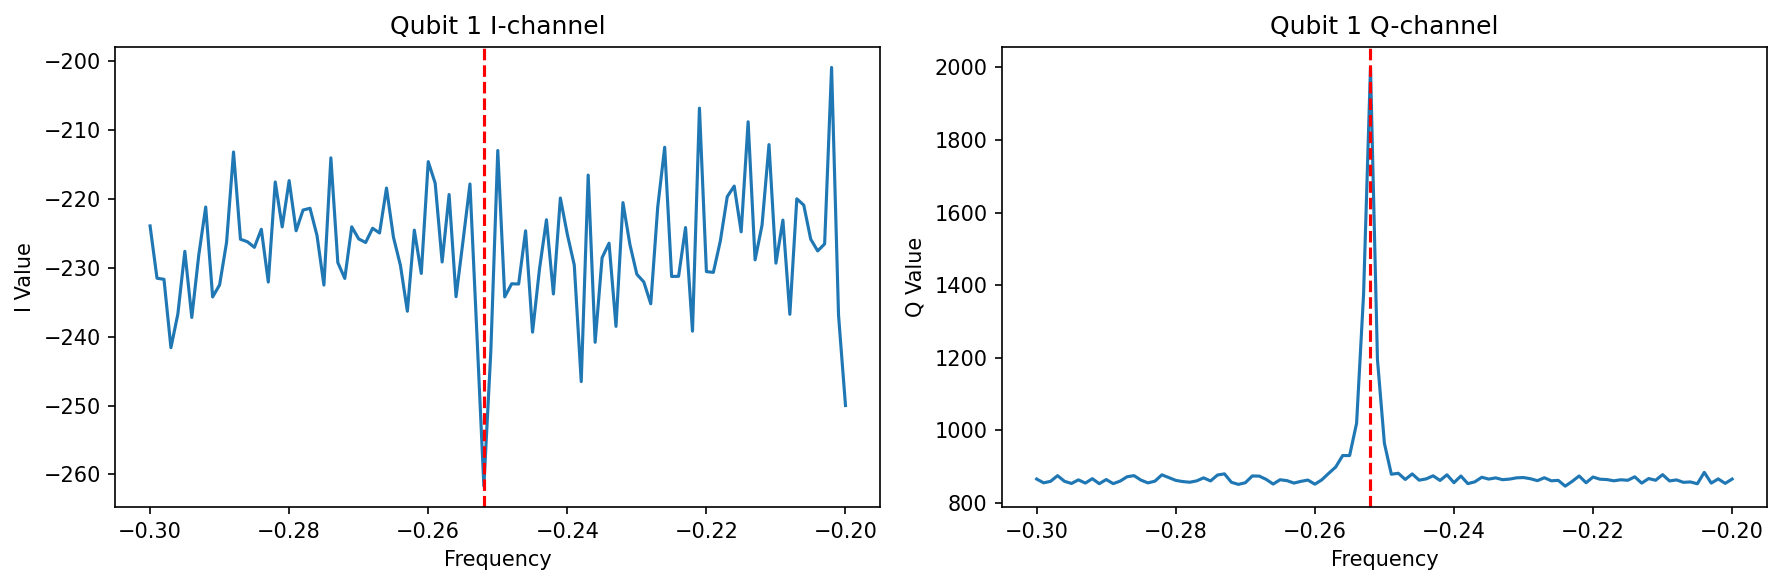

-0.252


In [33]:
freq = freq_list[np.argmin(dat["I1"])]
plotting.spectroscopy_plot(freq_list, values, [freq, freq], qubit_num=1)
print(freq)

In [22]:
f1=-0.2
f2=-0.3
num_steps=101
reps=500
spec_amp=0.1
sweep_time=10000
voltage_start=1
voltage_stop=-1#resistor is 300 ohm
voltage_steps = 21
I1,Q1,I2,Q2=spectroscopy_sweep(q4,q3,general_vals_dict,f1,f2,spec_amp,num_steps,sweep_time,reps,C4_address,voltage_start,voltage_stop,voltage_steps)


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 500
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.105672 sec
Captured 17 buffers (2.784296 buffers per sec)
Captured 52224 records (8553.357751 records per sec)
Transferred 855638016 bytes (140138213.389943 bytes per sec)
Patterns: 101
Records per pattern: 500
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.045857 sec
Captured 17 buffers (2.811843 buffers per sec)
Captured 5222

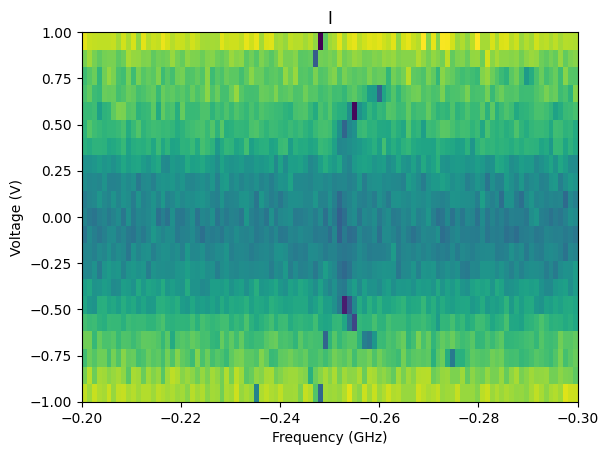

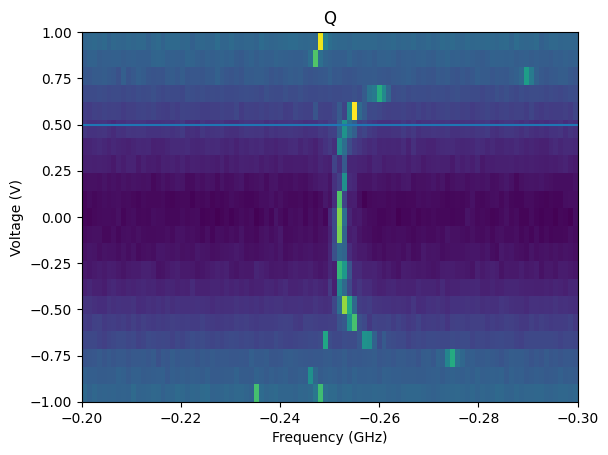

In [28]:
plt.imshow(I1, extent=[f1,f2,voltage_stop,voltage_start],aspect='auto' )
plt.ylabel('Voltage (V)')
plt.xlabel('Frequency (GHz)')
plt.title('I')
# plt.axvline(-0.108)
# plt.axhline(-1.42)
# plt.axhline(1.3)
plt.show()
plt.imshow(Q1, extent=[f1,f2,voltage_stop,voltage_start],aspect='auto' )
plt.ylabel('Voltage (V)')
plt.xlabel('Frequency (GHz)')


plt.axhline(0.5)
plt.title('Q')
plt.show()

In [1]:
num_steps = 101
reps = 500
sweep_time = 500
values, IQ_df = run_rabi(q4,q3,general_vals_dict,num_steps, sweep_time, reps)
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
if Qrange > Irange:
    print("Q")
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, Q, guess_vals=[11, 0.3, np.abs(np.max(Q) - np.min(Q)), 38, Q[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:
    print("I")
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, I, guess_vals=[11, 0.3, np.abs(np.max(I) - np.min(I)), 38, I[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))

NameError: name 'run_rabi' is not defined

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 500
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 11.121284 sec
Captured 17 buffers (1.528600 buffers per sec)
Captured 52224 records (4695.860654 records per sec)
Transferred 855638016 bytes (76936980.962135 bytes per sec)


<Figure size 800x800 with 0 Axes>

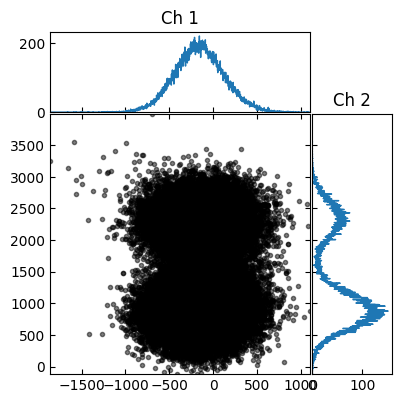

<Figure size 800x800 with 0 Axes>

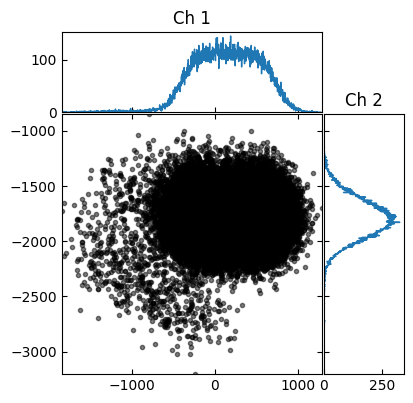

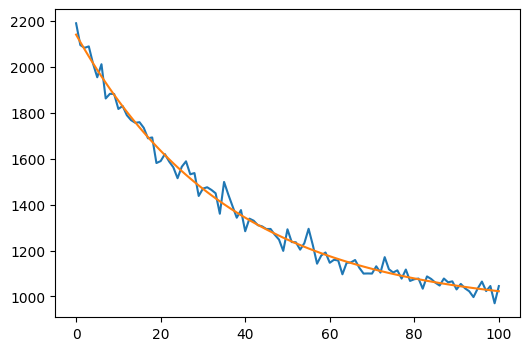



   amp: 1192.9652437672892
 gamma: 0.027585188660768832
offset: 947.4054704517321
[1.19296524e+03 2.75851887e-02 9.47405470e+02]
T1_ge = 36.2513380748482 μs


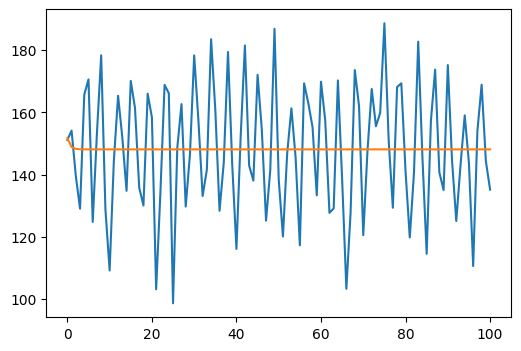



   amp: 3.612441041936649
 gamma: 1.5740580751772715
offset: 148.10636815080895
[  3.61244104   1.57405808 148.10636815]
T1_ge = 0.6353005748452956 μs


In [6]:
reps = 500
sweep_time = 100000
values, IQ_df = run_T1(q4,q3,general_vals_dict, sweep_time, reps)
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))
if Qrange>Irange:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,Q,guess_vals=[-Qrange,0.5,Q[100]])
else:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,I,guess_vals=[-Irange,0.5,I[100]])

print(T1_ge_fit_vals)
T1_ge = 1/T1_ge_fit_vals[1]
print("T1_ge = {} \u03BCs".format(T1_ge))
Q = IQ_df["Q2"]
I = IQ_df["I2"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))
if Qrange>Irange:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,Q,guess_vals=[-Qrange,0.5,Q[100]])
else:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,I,guess_vals=[-Irange,0.5,I[100]])

print(T1_ge_fit_vals)
T1_ge = 1/T1_ge_fit_vals[1]
print("T1_ge = {} \u03BCs".format(T1_ge))

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 10.759777 sec
Captured 33 buffers (3.066978 buffers per sec)
Captured 101376 records (9421.756960 records per sec)
Transferred 1660944384 bytes (154366066.038548 bytes per sec)


<Figure size 800x800 with 0 Axes>

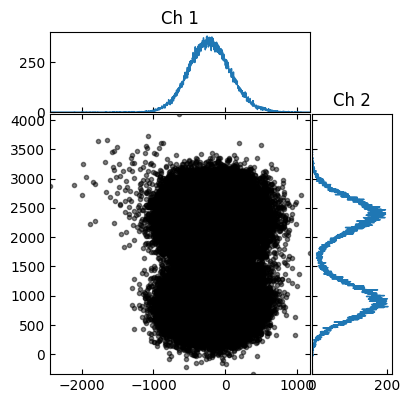

<Figure size 800x800 with 0 Axes>

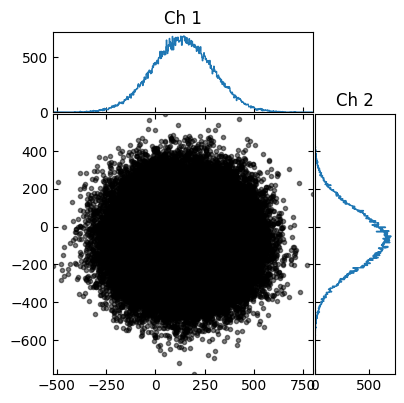

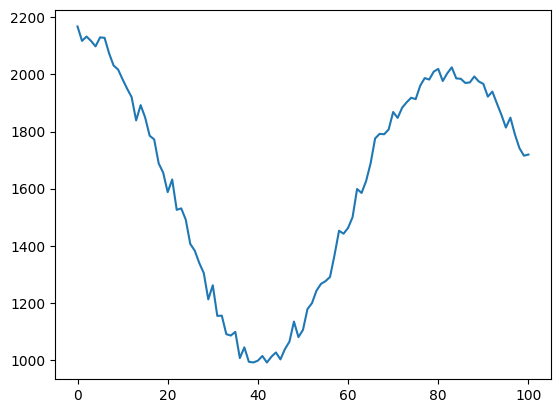

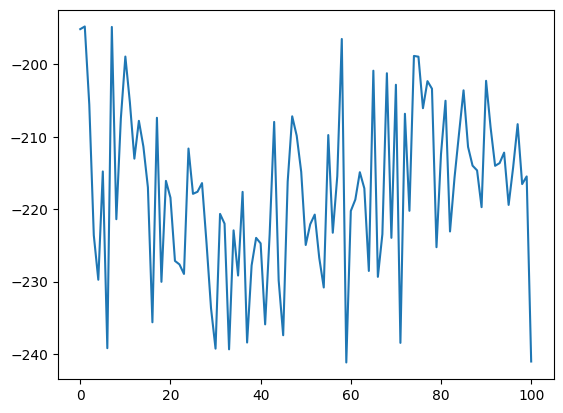

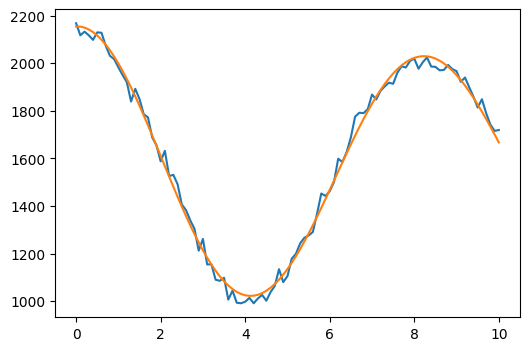



  freq: 0.12196065832059964 +/- 0.0005792540033454842
 gamma: 0.02853877239432014 +/- 0.002995655781953677
   amp: 600.5685650970721 +/- 9.259853706869881
 phase: 2606.614741222284 +/- 1.1144518062121906
offset: 1555.353355576256 +/- 3.5159381990581067
pi_pulse time: 4.099682691820531 +/- 0.0005792540033454842
T2* = 35.04004959228809 μs


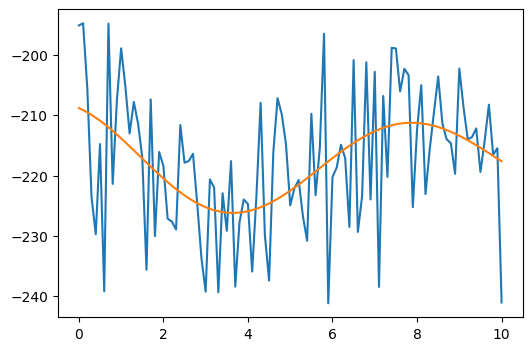



  freq: -0.11825463471676002 +/- 0.012408322979762475
 gamma: 0.04779255028529785 +/- 0.0858062077669339
   amp: -9.813838067940747 +/- 4.17408726002537
 phase: -111.20818683561134 +/- 22.52540882912017
offset: -217.97249617413874 +/- 1.2803352897156877
pi_pulse time: -4.228164090122853 +/- 0.012408322979762475
T2* = 20.92376309760612 μs


In [9]:
reps = 1000
sweep_time = 10000
num_steps = 101
values, IQ_df= run_ramsey(q4,q3,general_vals_dict,num_steps, sweep_time, reps)
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
plt.plot(Q)
plt.show()
plt.plot(I)
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))
T2_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q,guess_vals=[0 ,0.04600696770461763,-67.76128980276253,-263.4006117568909,0])
T2 = 1/T2_fit_vals[1]
print("T2* = {} \u03BCs".format(T2))
T2_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I,guess_vals=[0 ,0.04600696770461763,-67.76128980276253,-263.4006117568909,0])
T2 = 1/T2_fit_vals[1]
print("T2* = {} \u03BCs".format(T2))